Facial Recognition Model with FaceNet by **Moustapha LO**

The first thing to do is to import all required libraries. In this section, we will import all librairies we will use on the pproject and if we have an other library to use during the implementation, we come back and import it

In [7]:
from google.colab import drive
import os

from keras.models import load_model
import mtcnn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from os import listdir
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC

Face recognition is a technique of identification or verification of a person using their faces through an image or video. It captures, analyzes and compares patterns based on the person's facial details.
The complete Face Recognition system can be divided into three catgories:
1. Face Detection
2. Feature Extraction
3. Feature Classification  
The face detection process is an essential step as it detects and locates human faces in images and videos. Lot of methods are used for Face Detection process. We are going to use the MTCNN Face Detection Method because it gives the most occurat results. It works for faces having various orientations in images and can detect faces across various scales.

We are going to use the Indian celebrities dataset. It is a dataset of 100 Indian Celebrities available for Face Recognition. We downloaded the dataset and uploaded it on our drive. So, to access on th dataset, we have first to mount on our google drive

In [8]:
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


So we can start our implementation becaus we have access on our dataset.
1. FEATURE DETECTION 

We are going to implment three methods for the Feature Detction part:   
-get_face: to extract face;  
-fetch_faces: to fetch the face;  
-loaddataset: to get the array of face data and it's labels

In [10]:
# Method to extract face
def get_face(file_name, required_size = (160,160)):

  #Open, convert and assign MTCNN detector to image
  image = Image.open(file_name)
  image = image.convert('RGB')
  image_to_array = np.asarray(image)
  face_detector = MTCNN()
  detected = face_detector.detect_faces(image_to_array)

  # Fetch the coordinates fo the image
  x1, y1, width, height = detected[0]['box']
  x1, y1 = np.abs(x1), np.abs(y1)
  x2, y2 = x1 + width, y1 + height

  #Locate the coordinate of face in the image
  face_img = image_to_array[y1:y2, x1:x2]

  #Convert and resize image
  img =  Image.fromarray(face_img)
  img = img.resize(required_size)
  face_img_array = np.asarray(img)

  return face_img_array

# Method to fetch face
def fetch_faces(folder):

    faces = []
    index = 1

    for file in listdir(folder):
      file_path = folder  +  file
      face = get_face(file_path)
      faces.append(face)
 
    return faces

# Method to get data
def load_dataset(folder):
    X, y = [], []
    index = 1

    for dir in listdir(folder):
      file = dir + "/"
      #fetch all faces in subdirectory
      faces = fetch_faces(file)
      labels = [dir for _ in range(len(faces))]
      print("%d - %d images in the class %s "%(index, len(faces), dir))
      X.extend(faces)
      y.extend(labels)
      index = index + 1
    return np.asarray(X), np.asarray(y)

directory = os.chdir("/content/drive/MyDrive/Indian-celebrities/")
X_train, y_train = load_dataset(directory)
print(X_train.shape, y_train.shape)

1 - 15 images in the class Vidya_Balan 
2 - 15 images in the class Vivek_Oberoi 
3 - 15 images in the class Zareen_Khan 
4 - 15 images in the class Tiger_Shroff 
5 - 15 images in the class Yami_Gautam 
6 - 15 images in the class Vaani_Kapoor 
7 - 15 images in the class Uday_Chopra 
8 - 15 images in the class Varun_Dhawan 
9 - 15 images in the class Vicky_Kaushal 
10 - 15 images in the class Tusshar_Kapoor 
11 - 15 images in the class Sidharth_Malhotra 
12 - 15 images in the class Suniel_Shetty 
13 - 17 images in the class Sonam_Kapoor 
14 - 15 images in the class Taapsee_Pannu 
15 - 15 images in the class Sushant_Singh_Rajput 
16 - 15 images in the class Tamannaah_Bhatia 
17 - 15 images in the class Tabu 
18 - 22 images in the class Sonakshi_Sinha 
19 - 15 images in the class Shruti_Haasan 
20 - 15 images in the class Sunny_Deol 
21 - 15 images in the class Shraddha_Kapoor 
22 - 15 images in the class R_Madhavan 
23 - 15 images in the class Salman_Khan 
24 - 15 images in the class Saif

In [11]:
np.savez_compressed('Indian-celeb-dataset.npz',X_train, y_train)

2.FEATURE EXTRACTION

Feature Extraction is the basic and most important initializing step for face recognition. It extracts the biological components (features of the face which differ from person to person) of your face. No two people can have all the nodal points similar to each other except for identical twins.  
There are various methods which extract various combination of these nodal points.  
Two approach can be followed for Feature Extraction:  
-Shallow Approach (PCA, Cosin Similarity, LDA...)  
-Deep Approach (FaceNet Keras, VGG, etc.)  
We will be using the **FaceNet Keras** Model which is a one-shot model. It fetches 128 vector embeddings as a feature extractor.


In [13]:
#The extract_embeddings method will xtract the embeddings
def extract_embeddings(model, face_pixels):

  face_pixels = face_pixels.astype('float32')
  mean = face_pixels.mean()
  std = face_pixels.std()
  face_pixels = (face_pixels - mean)/std
  samples = np.expand_dims(face_pixels, axis=0)
  y_hat = model.predict(samples)

  return y_hat[0]


#Load dataset and get X_train and y_train
data = np.load('Indian-celeb-dataset.npz')
X_train, y_train = data['arr_0'], data['arr_1']
print(X_train.shape, y_train.shape)
model = load_model('/content/facenet_keras.h5')

# Get the face embeddings with the extract_embeddings method and convert to array
train_X = list()

for train in X_train:
  embeddings = extract_embeddings(model, train)
  train_X.append(embeddings)
train_X = np.asarray(train_X)

print(train_X.shape)


(1538, 160, 160, 3) (1538,)
(1538, 128)


In [14]:
np.savez_compressed('Indian-celeb-embeddings.npz', train_X, y_train)

3.FEATURE CLASSIFICATION   
Feature Classification is a geometry-based algorithm used to classsify the features of the test data among different classes of facial features in the training data. It can be done using various statistical approaches(Euclidian Distance, KNN, SVM, Cosine Similarity, etc.)
We will use the SVM method that creates an optimal hyperplane to classify the classes of training dataset basd on the different features of the face.

We are going to test with two images: One from the dataset and an other choosen randomly on the internet

Input test data shape:  (1, 160, 160, 3)
Input test embedding shape:  (1, 128)
Train data  = 1538, Test data = 1
0.9986996098829649


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, 'Prediction')

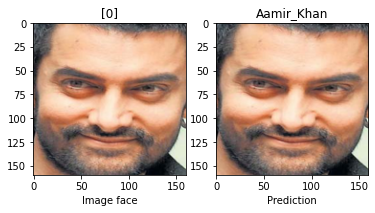

In [24]:
# Load image and apply Feature extraction
image_ = '/content/Aamir_Khan_0.jpg'
#plt.imshow(image_)
face = get_face(image_)
testx = np.asarray(face)
testx = testx.reshape(-1, 160, 160, 3)
print("Input test data shape: ", testx.shape)

# Get embddings
model = load_model('/content/facenet_keras.h5')
Xtest = list()
for pixels in testx:
  embeddings = extract_embeddings(model, pixels)
  Xtest.append(embeddings)
Xtest = np.asarray(Xtest)
print("Input test embedding shape: ",Xtest.shape)

dataset1 = np.load('Indian-celeb-dataset.npz')
X_tr, y_tr = dataset1['arr_0'], dataset1['arr_1']

dataset2 = np.load('Indian-celeb-embeddings.npz')
Xtrain, ytrain = dataset2['arr_0'], dataset2['arr_1']
print("Train data  = %d, Test data = %d"%(Xtrain.shape[0], Xtest.shape[0]))

# Encode input data by normalization
encoder = Normalizer(norm='l2')
Xtrain = encoder.transform(Xtrain)
Xtest = encoder.transform(Xtest)

# Endode labels data
test_y = ytrain
encoder2 = LabelEncoder()
encoder2.fit(ytrain)
ytrain = encoder2.transform(ytrain)
test_y = encoder2.transform(test_y)

# SVM classifier
model = SVC(kernel='linear', probability=True)
model.fit(Xtrain, ytrain)

# Make predictions
predictions = model.predict(Xtrain)
test = model.predict(Xtest)

predict_prob = model.predict_proba(Xtest)
max_ = max(predict_prob)

#Compute the accuracy
accuracy = accuracy_score(ytrain, predictions)

print(accuracy)

train = list(ytrain)
result = int(test)
if result in train:
  value_ = train.index(result)
#Show Input image
plt.subplot(1,2,1)
plt.imshow(face)
teest = encoder2.inverse_transform(test)
plt.title(test)
plt.xlabel("Image face")
#Show the Prdicted image
plt.subplot(1,2,2)
plt.imshow(X_tr[value_])
ytrain = encoder2.inverse_transform(ytrain)
plt.title(ytrain[value_])
plt.xlabel("Prediction")

The prediction is correct because the predicted image is the same as the input image

Input test data shape:  (1, 160, 160, 3)
Input test embedding shape:  (1, 128)
Train data  = 1538, Test data = 1
0.9986996098829649


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, 'Prediction')

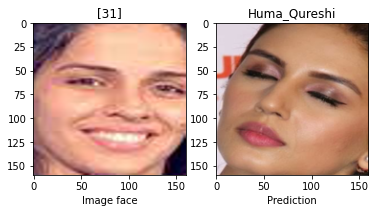

In [25]:
# Load image and apply Feature extraction
image_ = '/content/testImage.jpg'
#plt.imshow(image_)
face = get_face(image_)
testx = np.asarray(face)
testx = testx.reshape(-1, 160, 160, 3)
print("Input test data shape: ", testx.shape)

# Get embddings
model = load_model('/content/facenet_keras.h5')
Xtest = list()
for pixels in testx:
  embeddings = extract_embeddings(model, pixels)
  Xtest.append(embeddings)
Xtest = np.asarray(Xtest)
print("Input test embedding shape: ",Xtest.shape)

dataset1 = np.load('Indian-celeb-dataset.npz')
X_tr, y_tr = dataset1['arr_0'], dataset1['arr_1']

dataset2 = np.load('Indian-celeb-embeddings.npz')
Xtrain, ytrain = dataset2['arr_0'], dataset2['arr_1']
print("Train data  = %d, Test data = %d"%(Xtrain.shape[0], Xtest.shape[0]))

# Encode input data by normalization
encoder = Normalizer(norm='l2')
Xtrain = encoder.transform(Xtrain)
Xtest = encoder.transform(Xtest)

# Endode labels data
test_y = ytrain
encoder2 = LabelEncoder()
encoder2.fit(ytrain)
ytrain = encoder2.transform(ytrain)
test_y = encoder2.transform(test_y)

# SVM classifier
model = SVC(kernel='linear', probability=True)
model.fit(Xtrain, ytrain)

# Make predictions
predictions = model.predict(Xtrain)
test = model.predict(Xtest)

predict_prob = model.predict_proba(Xtest)
max_ = max(predict_prob)

#Compute the accuracy
accuracy = accuracy_score(ytrain, predictions)
print(accuracy)

train = list(ytrain)
result = int(test)
if result in train:
  value_ = train.index(result)
#Show Input image
plt.subplot(1,2,1)
plt.imshow(face)
teest = encoder2.inverse_transform(test)
plt.title(test)
plt.xlabel("Image face")
#Show the Prdicted image
plt.subplot(1,2,2)
plt.imshow(X_tr[value_])
ytrain = encoder2.inverse_transform(ytrain)
plt.title(ytrain[value_])
plt.xlabel("Prediction")

With the performances and accuracy, we can confirm that FaceNet is one of the most precise machine learning algorithms. Its performance is even better than that of the human eyes